In [19]:
import numpy as np
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#BC371B', '#BC881B', '#4FBC1B'])
%matplotlib inline

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [20]:
def plot_data(X, y):
    ax = plt.gca()
    ax.scatter(X[:,0], X[:,1], c=y, cmap=cm_bright)

In [21]:
class NeuralNet:
    """
    NN for multi-class classification with mini-batch
    Attributes:
    ...
    """
    
    def __init__(self, mbgd_size, neurons_in_layers, normalize = True, learning_rate = 0.01, num_iter = 30000):
        self.mbgd_size = mbgd_size
        self.neurons_in_layers = neurons_in_layers
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
    
    def __normalize(self, X, mean = None, std = None):
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s**2
        return X_new, m, s
    
    def __softmax(self, Z):
        eZ = np.exp(Z - np.max(Z))
        return eZ / np.sum(eZ, axis=0, keepdims=True)

    def __initialize_parameters(self):
        neurons_in_layers = self.neurons_in_layers
        parameters = {}
        for i in range(1, len(neurons_in_layers)):
            parameters["W" + str(i)] = np.random.randn(neurons_in_layers[i], neurons_in_layers[i - 1]) * np.sqrt(1 / neurons_in_layers[i - 1])
            parameters["b" + str(i)] = np.zeros((neurons_in_layers[i], 1))
        self.parameters = parameters
       
    def __forward_propagation(self, X):
        parameters = self.parameters
        caches = []
        A = X
        L = len(parameters) // 2

        for i in range(1, L):
            prev_A = A
            W = parameters["W"+str(i)]
            b = parameters["b"+str(i)]
            
            Z = np.dot(W, prev_A) + b
            linear_cache = (prev_A, W, b)
            
            A = self.__softmax(Z)
            activation_cache = Z
            
            cache = (linear_cache, activation_cache)            
            caches.append(cache)   
            
        W = parameters["W"+str(L)]
        b = parameters["b"+str(L)]
        
        Z = np.dot(W, A) + b
        linear_cache = (A, W, b)
            
        AL = self.__softmax(Z)
        activation_cache = Z
            
        cache = (linear_cache, activation_cache)            
        caches.append(cache)  
        
        return AL, caches
    
    def compute_cost(self, A, Y):
        J = -np.mean(Y.T * np.log(A.T+ 1e-8))
        return J
        
    def __backward_propagation(self, X, Y, caches):
        grads = {}
        AL = X
        L = len(caches)
        m = AL.shape[1]
        Y = Y.reshape(AL.shape)
        dAL = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
        
        linear_cache, activation_cache = caches[L-1]
        Z = activation_cache
        s = self.__softmax(Z)
        dZ = dAL * s * (1 - s)
        prev_A, W, b = linear_cache
        m = prev_A.shape[1]
        dW = 1 / m * np.dot(dZ, prev_A.T)
        db = 1 / m * np.sum(dZ, axis=1, keepdims=True)
        prev_dA = np.dot(W.T, dZ)
        
        grads["dA" + str(L-1)] = prev_dA
        grads["dW" + str(L)] = dW
        grads["db" + str(L)] = db
        
        for i in reversed(range(L-1)):
            linear_cache, activation_cache = caches[i]
            Z = activation_cache
            s = self.__softmax(Z)
            dZ = prev_dA * s * (1 - s)
            prev_A, W, b = linear_cache
            m = prev_A.shape[1]
            dW = 1 / m * np.dot(dZ, prev_A.T)
            db = 1 / m * np.sum(dZ, axis=1, keepdims=True)
            prev_dA = np.dot(W.T, dZ)
            
            grads["dA" + str(i)] = prev_dA
            grads["dW" + str(i + 1)] = dW
            grads["db" + str(i + 1)] = db
        return grads
   
    def __update_parameters(self, grads):
        parameters = self.parameters
        learning_rate = self.learning_rate

        for i in range(len(parameters) // 2):
            parameters["W" + str(i+1)] = parameters["W" + str(i+1)] - learning_rate * grads["dW" + str(i+1)]
            parameters["b" + str(i+1)] = parameters["b" + str(i+1)] - learning_rate * grads["db" + str(i+1)]
            
        self.parameters = parameters
        
    def __shuffle_and_separate(self, X, Y):            
        m = X.shape[1]
        SS_data = [] #for shuffled and separated data
        mbgd_size = self.mbgd_size
        
        perm = list(np.random.permutation(m))
        shuff_X = X[:, perm]        
        shuff_Y = Y[:, perm]

        for i in range(0, int(np.floor(m/mbgd_size))):
            batch_X = shuff_X[:, i*mbgd_size : (i + 1)*mbgd_size]
            batch_Y = shuff_Y[:, i*mbgd_size : (i + 1)*mbgd_size]
            
            batch = (batch_X, batch_Y)
            SS_data.append(batch)

        if m % mbgd_size != 0:
            batch_X = shuff_X[:, int(np.floor(m/mbgd_size))*mbgd_size:]
            batch_Y = shuff_Y[:, int(np.floor(m/mbgd_size))*mbgd_size:]
            
            batch = (batch_X, batch_Y)
            SS_data.append(batch)

        return SS_data
        
    def fit(self, X_vert, Y_vert, print_cost = True):
        
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        m = X.shape[1]
        costs = []
        
        self.__initialize_parameters()

        for i in range(0, self.num_iter):
            SS_data = self.__shuffle_and_separate(X, Y)
            
            for (batch_X, batch_Y) in SS_data:
                A, caches = self.__forward_propagation(batch_X)

                cost = self.compute_cost(A, batch_Y)

                grads = self.__backward_propagation(A, batch_Y, caches)

                self.__update_parameters(grads)
            
            costs.append(cost)

            if print_cost and i % 100 == 0:
                print("{}-th iteration: {}".format(i, cost))

            if i % 100 == 0:
                costs.append(cost)

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *100")
            plt.show()
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)[0]
        return probs.T
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)
        return np.argmax(positive_probs, axis = 1)

In [22]:
iris = load_iris()
X = iris.data
Y = iris.target

print('Dataset: X={}, y={}'.format(X.shape, Y.shape))

Dataset: X=(150, 4), y=(150,)


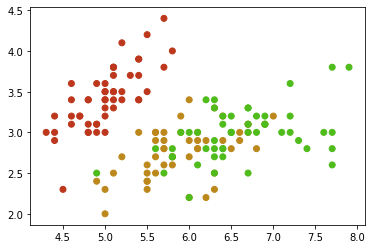

In [23]:
plot_data(X, Y)

In [18]:
cls = NeuralNet(mbgd_size = 1024, neurons_in_layers = [4, 15, 3], normalize = True, learning_rate = 0.1, num_iter = 2000)

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=10)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((120, 4), (30, 4), (120,), (30,))

In [25]:
Y_train_transf = np.zeros([len(Y_train), 3])
for i in range(0, len(Y_train)):
    for j in range(0, 3):
        if Y_train[i] == j:
            Y_train_transf[i][j] = 1

Y_train_transf

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1

0-th iteration: 0.3679088687710862
100-th iteration: 0.266303408641202
200-th iteration: 0.1847608231443175
300-th iteration: 0.14606443310530265
400-th iteration: 0.12513687096487497
500-th iteration: 0.11078770643336089
600-th iteration: 0.09993673324407992
700-th iteration: 0.09124969524530967
800-th iteration: 0.08403562484605548
900-th iteration: 0.077856379551497
1000-th iteration: 0.07235156057484698
1100-th iteration: 0.06704380042496029
1200-th iteration: 0.060332980211361034
1300-th iteration: 0.05168260768152156
1400-th iteration: 0.047905905493373514
1500-th iteration: 0.04508825132151028
1600-th iteration: 0.04273591807255739
1700-th iteration: 0.04071077591261253
1800-th iteration: 0.038934659094807055
1900-th iteration: 0.037356465449877294


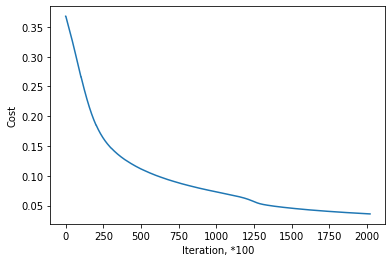

In [26]:
cls.fit(X_train, Y_train_transf)

In [27]:
print(cls.parameters)

{'W1': array([[ 0.2350514 ,  0.00782539, -0.52434073, -0.39226269],
       [ 1.64080969, -1.54303437,  1.83076624,  3.86076563],
       [ 0.35912776,  0.43161083,  0.82880035,  0.51080672],
       [ 1.01415849, -0.19309755, -0.48500958, -1.06210664],
       [ 0.41573979, -0.46756533, -0.12082119, -0.08335501],
       [-0.13183658,  0.10848376,  0.50277856,  1.04218769],
       [-0.01476238, -1.13976161, -0.53299581,  0.18070149],
       [-0.50717217,  0.39357106, -0.71432849, -0.0299144 ],
       [-0.5243654 , -0.83364446, -0.47529627,  0.34117827],
       [-0.20666805, -0.14357131,  0.05703371, -0.21219983],
       [ 0.93190787,  0.0306711 ,  0.63895203,  0.02679842],
       [ 0.15699604,  0.21068229, -0.22783332,  0.0989052 ],
       [-0.13250322,  0.09957882, -0.33214773, -1.23598474],
       [ 2.13161934, -1.48502062,  0.00425693,  0.39837014],
       [-1.69218524,  0.36509119, -0.73380894, -2.7726934 ]]), 'b1': array([[ 0.02741012],
       [-0.4881059 ],
       [-0.03457251],
    

In [28]:
Y_prob = cls.predict_proba(X_train)
Y_prob

array([[0.00848923, 0.95887088, 0.03263989],
       [0.01097121, 0.95426835, 0.03476044],
       [0.01135226, 0.38032329, 0.60832445],
       [0.001764  , 0.0177211 , 0.9805149 ],
       [0.00266382, 0.03357584, 0.96376034],
       [0.98530975, 0.01236322, 0.00232703],
       [0.00259298, 0.02922001, 0.96818701],
       [0.00185636, 0.01906475, 0.97907889],
       [0.00178328, 0.0180804 , 0.98013632],
       [0.00187449, 0.01943617, 0.97868934],
       [0.98463242, 0.01295158, 0.002416  ],
       [0.9837783 , 0.01369389, 0.00252781],
       [0.0211372 , 0.93686699, 0.04199581],
       [0.92506857, 0.06745093, 0.0074805 ],
       [0.03148134, 0.84230208, 0.12621658],
       [0.9853372 , 0.01233877, 0.00232403],
       [0.01368768, 0.833742  , 0.15257032],
       [0.02282122, 0.4570278 , 0.52015097],
       [0.00253163, 0.02929303, 0.96817533],
       [0.00179142, 0.01801495, 0.98019363],
       [0.01284451, 0.58507394, 0.40208155],
       [0.00203491, 0.0208515 , 0.97711359],
       [0.

In [29]:
Y_train_hat = cls.predict(X_train)
Y_train_hat

array([1, 1, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 1, 0, 1, 0, 1, 2, 2, 2, 1, 2,
       1, 1, 1, 0, 0, 1, 0, 2, 0, 0, 2, 1, 2, 0, 2, 0, 1, 2, 0, 2, 2, 2,
       2, 1, 0, 1, 2, 1, 0, 2, 1, 1, 0, 0, 0, 1, 2, 2, 1, 0, 0, 0, 2, 2,
       1, 1, 2, 2, 2, 1, 1, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       2, 0, 1, 1, 2, 0, 2, 0, 1, 2, 2, 2, 0, 1, 2, 2, 1, 1, 2, 0, 2, 0,
       0, 1, 0, 2, 2, 2, 1, 0, 2, 0], dtype=int64)

In [33]:
accuracy_score(Y_test, Y_test_hat)

1.0

In [31]:
Y_test_hat = cls.predict(X_test)
Y_test_hat


array([1, 2, 0, 1, 0, 1, 1, 1, 0, 1, 1, 2, 1, 0, 0, 2, 1, 0, 0, 0, 2, 2,
       2, 0, 1, 0, 1, 1, 1, 2], dtype=int64)

In [32]:
accuracy_score(Y_test, Y_test_hat)

1.0